# Flex Net: A Configurable Neural Network for Sound Parsing

### Avant Garde Composer

Code to generate batches of random marimba compositions (with piano roll and corresponding audio)

In [2]:
import tensorflow as tf
from sonic import *

class Generate_Batch():
    def __init__(self, batch_size, length_in_beats, sample_rate, bpm):
        self.song = Song(SampleBank(), length_in_beats, bpm, sample_rate)
        self.batch_size = batch_size
        self.num_inst_samples = self.song.num_inst_samples
        self.length_in_beats = length_in_beats
        self.bpm = bpm
        self.sr = sample_rate
        self.N = self.sr * self.length_in_beats * 60 // self.bpm
        self.samples_per_beat = (self.sr * 60) // self.bpm
        self.batch_audio = tf.Variable(tf.zeros([self.batch_size, self.length_in_beats-4, self.samples_per_beat*5], dtype=tf.float32))
        self.batch_piano_roll = tf.Variable(tf.zeros([self.batch_size, self.length_in_beats-4, self.num_inst_samples], dtype=tf.float32))
    
    #@tf.function
    def __chop__(self, song_output, song_notes_float):
        audio = tf.TensorArray(tf.float32, size=(self.length_in_beats-4), element_shape=(self.samples_per_beat*5,))
        piano_roll = tf.TensorArray(tf.float32, size=(self.length_in_beats-4), element_shape=(self.num_inst_samples,))
        for j in tf.range(self.song.length_in_beats - 4):
            audio.write(j, song_output[j*self.samples_per_beat:(j+5)*self.samples_per_beat])
            piano_roll.write(j, tf.reshape(song_notes_float, [self.song.length_in_beats, self.song.num_inst_samples])[j])
        return audio.stack(), piano_roll.stack()
    
    #@tf.function
    def __call__(self):
        for i in range(self.batch_size):
            self.song.zero()
            for j in range(np.random.choice([3,4,5,6,7,8,9,10,11,12])):
                self.song.generate()
            self.song.compile()
            audio, piano_roll = self.__chop__(self.song.output, self.song.notes_float)
            self.batch_audio[i].assign(audio)
            self.batch_piano_roll[i].assign(piano_roll)
        return self.batch_audio, self.batch_piano_roll    

In [3]:
batch_size = 10
batches_per_epoch = 100

generate_batch = Generate_Batch(batch_size, 4*10, 44100, 60*10)

Marimba_cord_ff  --- notes  36  through  96


In [4]:
# Example of a random composition

from IPython.display import Audio

generate_batch.song.generate()
example_composition = generate_batch.song.output.numpy()

Audio(example_composition, rate=44100, autoplay=True)

## Neural Network Classes

In [5]:
from neural import *

class Network(tf.Module):
    def __init__(self, name=None):
        super(Network, self).__init__(name=name)
        self.layers = []
        
                
        sample_rate = 44100                 # 44.1khz sample rate
        frame_length = sample_rate // 10    # frame size of 0.1 seconds
        num_frames = 5                      # five frames read at a time
        input_features = int(frame_length * num_frames)
    
        self.layers.append(DisperseLayer(input_features, frame_length, 1.0))
        num_chunks = num_frames
        
        self.layers.append(RFFTLayer(self.layers[-1].chunk_size))
        
        self.layers.append(SeluLayer(self.layers[-1].output_features, self.layers[-1].output_features // 16, scaling=1/1000))
        self.layers.append(SeluLayer(self.layers[-1].output_features, self.layers[-1].output_features // 2, scaling=1/100))
        self.layers.append(SeluLayer(self.layers[-1].output_features, self.layers[-1].output_features // 2, scaling=1/50))
    
        
        self.layers.append(JoinLayer(self.layers[-1].output_features, num_chunks))

        self.layers.append(SeluLayer(self.layers[-1].output_features, self.layers[-1].output_features // 4, scaling=1.0))
        self.layers.append(SigmoidLayer(self.layers[-1].output_features, 61, scaling=1/10))
        
        self.scalings = tuple([scaling for layer in self.layers for scaling in layer.scalings])

    def save(self, path):
        if not os.path.exists(path):
            os.makedirs(path)
        for i, layer in enumerate(self.layers):
            if not os.path.exists(os.path.join(path, f'layer_{i}')):
                os.makedirs(os.path.join(path, f'layer_{i}'))
            layer.save(os.path.join(path, f'layer_{i}'))
            
    def load(self, path):
        for i, layer in enumerate(self.layers):
            layer.load(os.path.join(path, f'layer_{i}'))
        
    def apply(self, data, layers):
        if len(layers) == 1:
            return layers[0](data)
        else:
            return self.apply(layers[0](data), layers[1:])

    #@tf.function
    def __call__(self, data):
        x = data
        for i, layer in enumerate(self.layers):
            x = layer(x)
        return x
        #return self.apply(data, self.layers)
        
    def reset(self):
        for layer in self.layers:
            layer.reset()

network = Network()

Disperse Layer. Input Features: 22050 Chunk Size: 4410 Num Chunks: 5
RFFT Layer. Input Features: 4410 Output Features: 8194
SELU Layer. Input Features: 8194 Output Features: 512
SELU Layer. Input Features: 512 Output Features: 256
SELU Layer. Input Features: 256 Output Features: 128
Join Layer. Input Chunk Size: 128 Num Input Chunks: 5 Output Features: 640
SELU Layer. Input Features: 640 Output Features: 160
Sigmoid Layer. Input Features: 160 Output Features: 61


In [6]:
def clean_output(arr):
    N = arr.shape[0]
    M = arr.shape[1]
    output = np.zeros([N, M])
    for i in range(N):
        for j in range(M):
            output[i][j] = int(max(0, min(127, round(128 * arr[i][j]))))
    return output

In [7]:
network.reset()

In [13]:
from IPython.display import display, clear_output, Audio
import seaborn as sns
import sys, signal
import matplotlib.pyplot as plt
import plotting

keep_going = True
def signal_handler(signal, frame):
    global keep_going
    keep_going = False
signal.signal(signal.SIGINT, signal_handler)

#@tf.function
def loss(trainable_variables, scalings, notes_actual, notes_predicted):
    #note_correctness_error = 10000*tf.reduce_mean((notes_actual - notes_predicted) ** 2)
    #note_correctness_error = 1 - tf.reduce_mean(tf.reduce_mean(((1/128) + notes_actual) * ((1/128) + notes_predicted), axis=-1) / (tf.reduce_mean(((1/128) + notes_predicted) ** 2, axis=-1) ** (1/2) * tf.reduce_mean(((1/128) + notes_actual) ** 2, axis=-1) ** (1/2)))
    #energy_actual = 150*tf.reduce_mean(notes_actual ** 2, axis=-1) - (tf.reduce_mean(notes_actual, axis=-1) ** 2)
    #energy_predicted = 150*tf.reduce_mean(notes_predicted ** 2, axis=-1) - (tf.reduce_mean(notes_predicted, axis=-1) ** 2)
    #mean_energy_error = tf.reduce_mean(tf.abs(energy_actual - energy_predicted))
    #amplitude = 10*tf.minimum(tf.maximum(1.0 - tf.reduce_max(notes_predicted), 0.0), 1.0)
    #loss = (note_correctness_error + mean_energy_error)
    note_cost = 200*tf.reduce_mean(-notes_actual * tf.math.log(0.0000000001 + notes_predicted) - (1 - notes_actual) * tf.math.log(1.0000000001 - notes_predicted))
    regularization_cost = 0.0
    for i in range(len(trainable_variables)):
        regularization_cost +=  tf.reduce_mean(-tf.math.minimum(trainable_variables[i], 0.0)) #* (1 / scalings[i])
    cost = note_cost + regularization_cost
    tf.print('Cost:', cost, 'Note Cost:', note_cost, 'Regularization Cost:', regularization_cost)
    #tf.print('Loss', loss, 'Note Cosine Error', note_correctness_error, ', Energy Error', mean_energy_error)
    #tf.print('loss', loss)#, 'note_correctness_error', note_correctness_error, 'mean_energy_error', mean_energy_error)
    return cost
    

@tf.function
def grad(network, input_pcms, notes_actual):
    with tf.GradientTape() as tape:
        tape.watch(network.trainable_variables)
        notes_predicted = network(input_pcms)
        loss_value = loss(network.trainable_variables, network.scalings, notes_actual, notes_predicted)
    return loss_value, notes_predicted, tf.clip_by_global_norm(tape.gradient(loss_value, network.trainable_variables), 1000000.0)

#@tf.function
def apply_grads(trainable_vars, grads, scalings, learning_rate):
    for i in range(len(grads)):
        trainable_vars[i].assign_sub(learning_rate * (1 / scalings[i] ** 2) * grads[i])

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.001) #, momentum=0.01) #, momentum=0.1, nesterov=True)
optimizer=tf.keras.optimizers.SGD(learning_rate=0.001)


num_inst_samples = 61
length_in_seconds = 4
quantization = 10
length_in_beats = length_in_seconds * quantization




learning_rate = 0.000001

grads = tuple(tf.Variable(tf.zeros_like(var, dtype=tf.float32)) for var in network.trainable_variables)

i = -1
while keep_going:
    i += 1
    input_pcms, notes_actual = generate_batch()

    loss_value, notes_predicted, (new_grads, global_norm) = grad(network, input_pcms, notes_actual)
    print('Global Norm:', global_norm.numpy())
    #if (2 ** -120) < global_norm.numpy() < 1.0:
    #    scaling = 1.0 / global_norm.numpy()
    #else:
    #    scaling = 1.0    
    for j in range(len(grads)):#[0,1]: #[4,5,6,7,8,9]:
        grads[j].assign_add(tf.where(tf.math.is_nan(new_grads[j]), tf.zeros_like(new_grads[j]), new_grads[j]) / batches_per_epoch)

    #apply_grads(network.trainable_variables, new_grads, learning_rate, scaling)
    
    if i % 100 == 99:
        clear_output()
        
    if i % 10 == 0:
        pass
        #fig = plotting.error(notes_predicted, notes_actual)
        #display(fig)
        #plt.close(fig)
        #del fig

    
    if (i % batches_per_epoch) == (batches_per_epoch - 1):
        apply_grads(network.trainable_variables, grads, network.scalings, learning_rate)
        #optimizer.apply_gradients(zip(grads, network.trainable_variables))
    
        for j in range(len(grads)):
            grads[j].assign(tf.zeros_like(network.trainable_variables[j], dtype=tf.float32))

        print(f'Epoch {i // batches_per_epoch} completed!')
        
    if i % 1000 == 999:
        network.save('checkpoint4')
        print('Network Parameters Saved!')

    print('Step', i, 'complete.')


Epoch 189 completed!
Network Parameters Saved!
Step 18999 complete.
Cost: 13.4957809 Note Cost: 11.2953949 Regularization Cost: 2.20038557
Global Norm: 4.5859246
Step 19000 complete.
Cost: 13.5111923 Note Cost: 11.3108063 Regularization Cost: 2.20038557
Global Norm: 4.3024335
Step 19001 complete.
Cost: 11.4097 Note Cost: 9.20931435 Regularization Cost: 2.20038557
Global Norm: 3.4186928
Step 19002 complete.
Cost: 13.3682365 Note Cost: 11.1678505 Regularization Cost: 2.20038557
Global Norm: 3.1633806
Step 19003 complete.
Cost: 14.1271667 Note Cost: 11.9267807 Regularization Cost: 2.20038557
Global Norm: 4.8361363
Step 19004 complete.
Cost: 14.5853748 Note Cost: 12.3849888 Regularization Cost: 2.20038557
Global Norm: 4.6558676
Step 19005 complete.
Cost: 13.6485939 Note Cost: 11.4482079 Regularization Cost: 2.20038557
Global Norm: 4.1499667
Step 19006 complete.
Cost: 14.7960606 Note Cost: 12.5956745 Regularization Cost: 2.20038557
Global Norm: 4.2240953
Step 19007 complete.
Cost: 13.671066

Global Norm: 4.131375
Step 19071 complete.
Cost: 11.9377117 Note Cost: 9.73732567 Regularization Cost: 2.20038557
Global Norm: 4.180713
Step 19072 complete.
Cost: 15.0155544 Note Cost: 12.8151684 Regularization Cost: 2.20038557
Global Norm: 4.6430993
Step 19073 complete.
Cost: 14.7844067 Note Cost: 12.5840216 Regularization Cost: 2.20038557
Global Norm: 5.4726787
Step 19074 complete.
Cost: 13.7167168 Note Cost: 11.5163307 Regularization Cost: 2.20038557
Global Norm: 4.8181767
Step 19075 complete.
Cost: 13.1113472 Note Cost: 10.9109621 Regularization Cost: 2.20038557
Global Norm: 5.163892
Step 19076 complete.
Cost: 11.7990017 Note Cost: 9.59861565 Regularization Cost: 2.20038557
Global Norm: 4.041343
Step 19077 complete.


### Saving and Loading

In [ ]:
network.save('checkpoint4')

In [8]:
network.load('checkpoint3')

### To run a single test example

Cost: 13.1899357 Note Cost: 11.0443611 Regularization Cost: 2.14557457


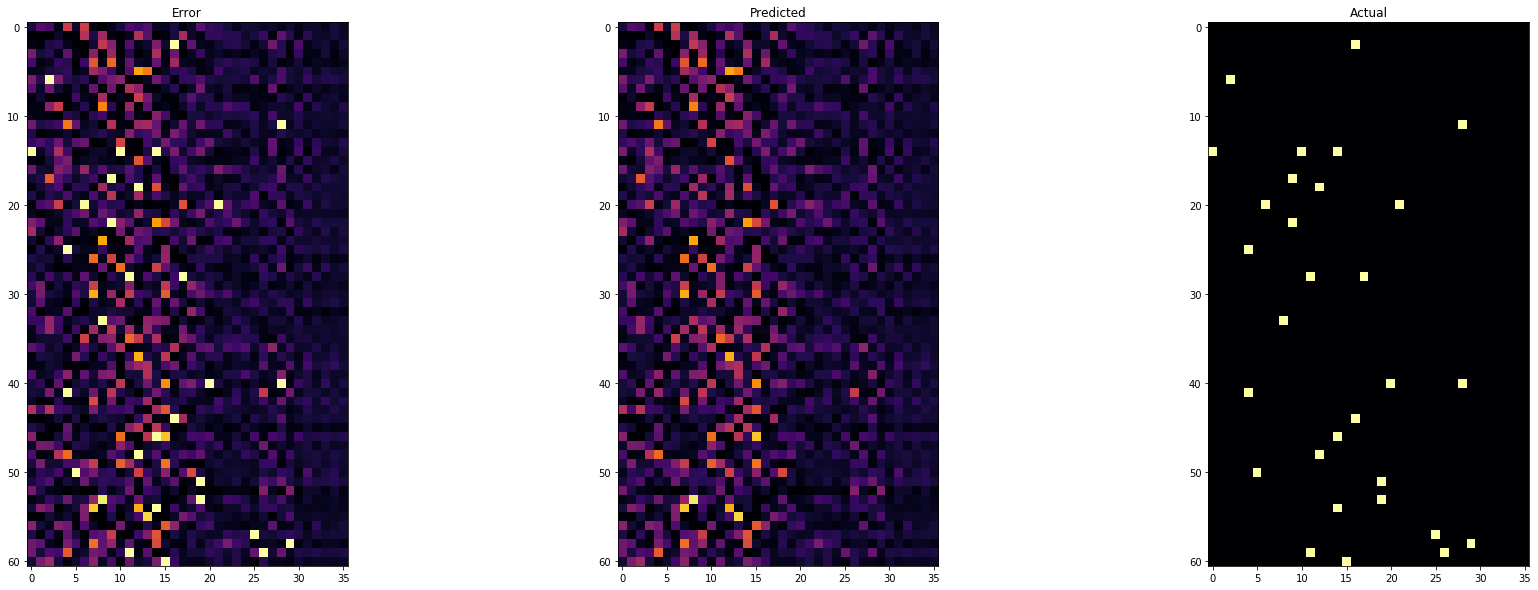

In [12]:
import plotting

input_pcms, notes_actual = generate_batch()

loss_value, notes_predicted, (new_grads, global_norm) = grad(network, input_pcms, notes_actual)
        
plt = plotting.error(notes_predicted, notes_actual)

del plt

In [ ]:
import gc

gc.collect()